# Regression model for metadata

In [202]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import itertools

### Loading the data

In [203]:
report = "reports_mid_price"
y_metrics = pd.read_csv(f"../../reports_log/{report}/tot_loss_lstm.csv", index_col=0)["normalized_rmse"]
Y = y_metrics
# X = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:]
X = pd.read_csv("../../data/raw/meta_data_with_LOB.csv", index_col=2).iloc[:, 1:]

tickers = y_metrics.index
X = X.loc[tickers, :]

In [204]:
textual_columns = ["sectorKey", "industryKey"]
X = X.drop(columns=textual_columns)

In [205]:
X["floatRatio"] = X["floatShares"] / X["sharesShort"]

nonsensical = [
    "auditRisk",
    "boardRisk",
    "compensationRisk",
    "shareHolderRightsRisk",
    "overallRisk",
    "dividendRate",
    "targetHighPrice",
    "targetLowPrice",
    "recommendationMean",
    "floatShares",
    "sharesShort", 
    "sharesShortPriorMonth", 
    "enterpriseValue", 
    "totalCash",
    # "ebitda",
    "totalDebt",
    "totalRevenue",
    "freeCashflow",
    "operatingCashflow",
]

other_columns = [
    "Unnamed: 0_x",
    "Unnamed: 0_y",
]

X = X.drop(columns=nonsensical + other_columns)

In [206]:
len(X.columns)
X.columns

Index(['fullTimeEmployees', 'dividendYield', 'fiveYearAvgDividendYield',
       'beta', 'trailingPE', 'forwardPE', 'marketCap',
       'priceToSalesTrailing12Months', 'profitMargins', 'heldPercentInsiders',
       'heldPercentInstitutions', 'shortRatio', 'priceToBook',
       'earningsQuarterlyGrowth', 'trailingEps', 'pegRatio',
       'enterpriseToRevenue', 'enterpriseToEbitda', 'numberOfAnalystOpinions',
       'ebitda', 'quickRatio', 'debtToEquity', 'returnOnAssets',
       'returnOnEquity', 'earningsGrowth', 'revenueGrowth', 'grossMargins',
       'ebitdaMargins', 'operatingMargins', 'trades_per_day', 'avg_rel_spread',
       'log_trades_per_day', 'floatRatio'],
      dtype='object')

### Some cleaning

In [207]:
significant_tickers = [
    "KEY",
    "HAL",
    "BELFB",
    "FITB",
    "ESRT",
    "EPM",
    "BTU",
    "CWT",
    "ARTNA",
    "DOMO",
]
Y = Y.loc[Y.index.isin(significant_tickers)]
X = X.loc[X.index.isin(significant_tickers)]
# Y.loc[Y >= 1] = 1
# Y = 1-Y**2

# too_high_error_tickers = Y[Y >= 1.01].index
# X = X.drop(too_high_error_tickers)
# Y = Y.drop(too_high_error_tickers)

columns_to_log_transform = [
    "fullTimeEmployees", 
    "marketCap",
]

new_column_names = ["log_" + col for col in columns_to_log_transform]

for col, new_col in zip(columns_to_log_transform, new_column_names):
    X.loc[:, new_col] = np.log(X.loc[:, col])
    X = X.drop(columns=col)    

In [208]:
# X["dividendYield"] = X["dividendYield"].fillna(0)
# X["fiveYearAvgDividendYield"] = X["dividendYield"].fillna(0)
# X["trailingPE"] = X["trailingPE"].max()
# X["enterpriseToEbitda"] = X["enterpriseToEbitda"].max()



In [209]:
X.isna().sum()

dividendYield                   1
fiveYearAvgDividendYield        2
beta                            0
trailingPE                      1
forwardPE                       0
priceToSalesTrailing12Months    0
profitMargins                   0
heldPercentInsiders             0
heldPercentInstitutions         0
shortRatio                      0
priceToBook                     1
earningsQuarterlyGrowth         2
trailingEps                     0
pegRatio                        3
enterpriseToRevenue             0
enterpriseToEbitda              2
numberOfAnalystOpinions         1
ebitda                          2
quickRatio                      2
debtToEquity                    3
returnOnAssets                  0
returnOnEquity                  1
earningsGrowth                  2
revenueGrowth                   0
grossMargins                    2
ebitdaMargins                   2
operatingMargins                0
trades_per_day                  0
avg_rel_spread                  0
log_trades_per

### Optimal subset

In [210]:
imputer = IterativeImputer(random_state=42)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

In [ ]:
max_predictors_in_model = 5

best_bic = float('inf')
best_subset = None

for k in range(1, max_predictors_in_model + 1):  
    print(f"using up to {k-1} of {max_predictors_in_model} predictors:")
    print(f"best bic: {best_bic}")
    print(f"best subset: {best_subset}")
    print("-"*100)
    for subset in itertools.combinations(X.columns, k):
        
        X_subset = X[list(subset)]
        corr_matrix = X_subset.corr()
        
        # dont allow correlation of over 0.7
        if ((corr_matrix >= 0.7).sum() >= 2).any():
            # print(subset)
            continue

        X_subset = sm.add_constant(X_subset)  # Add intercept
        model = sm.OLS(y_metrics, X_subset).fit(cov_type="HC2")

        bic = model.bic
        
        if bic < best_bic:
            best_bic = bic
            best_subset = subset

print(f"Best Subset: {best_subset}")
print(f"Best BIC: {best_bic}")

using up to 0 of 5 predictors:
best bic: inf
best subset: None
----------------------------------------------------------------------------------------------------
using up to 1 of 5 predictors:
best bic: -402.4141488097845
best subset: ('numberOfAnalystOpinions',)
----------------------------------------------------------------------------------------------------
using up to 2 of 5 predictors:
best bic: -402.7240441953366
best subset: ('dividendYield', 'numberOfAnalystOpinions')
----------------------------------------------------------------------------------------------------
using up to 3 of 5 predictors:
best bic: -402.7240441953373
best subset: ('dividendYield', 'trailingPE', 'numberOfAnalystOpinions')
----------------------------------------------------------------------------------------------------
using up to 4 of 5 predictors:
best bic: -402.7240441953373
best subset: ('dividendYield', 'trailingPE', 'numberOfAnalystOpinions')
-------------------------------------------------

In [211]:
# best_subset = [
#     'profitMargins', 
#     'heldPercentInstitutions', 
#     'returnOnAssets', 
#     'operatingMargins', 
#     'log_fullTimeEmployees'
#     # "targetHighPrice"
# ]
best_subset = ("numberOfAnalystOpinions", "trailingEps", "dividendYield", "log_marketCap")
best_subset = ("trailingEps", "dividendYield", "log_marketCap")
print(best_subset)
X = X[list(best_subset)]

('trailingEps', 'dividendYield', 'log_marketCap')


In [212]:
# Ensure you have no nan-values
X.isna().sum()

trailingEps      0
dividendYield    0
log_marketCap    0
dtype: int64

### Save the data

In [213]:
# X.to_csv("../../data/processed/X_regression.csv")
# Y.to_csv("../../data/processed/Y_regression.csv")

In [214]:
# X_copy = X.copy()
# X_copy.columns

In [215]:
# X = X_copy[["numberOfAnalystOpinions", "trailingEPS", "dividendYield"]]

### OLS

In [216]:
model = OLS(Y, add_constant(X))
result = model.fit(cov_type='HC2')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     11.86
Date:                Mon, 16 Dec 2024   Prob (F-statistic):            0.00620
Time:                        19:29:20   Log-Likelihood:                 39.019
No. Observations:                  10   AIC:                            -70.04
Df Residuals:                       6   BIC:                            -68.83
Df Model:                           3                                         
Covariance Type:                  HC2                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0669      0.034     31.294      0.000       1.000       1.134
trailingEps      -0.0003      0.001     -0.222      0.824      -0.002       0.002
dividendYield    -0.0761      0.065     -1.163      0.245      -0.204       0.052
log_marketCap    -0.0033      0.002     -2.135      0.033      -0.006      -0.000
==============================================================================
Omnibus:                        1.167   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                0.813
Skew:                          -0.612   Prob(JB):                        0.666
Kurtosis:                       2.327   Cond. No.                     1.30e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


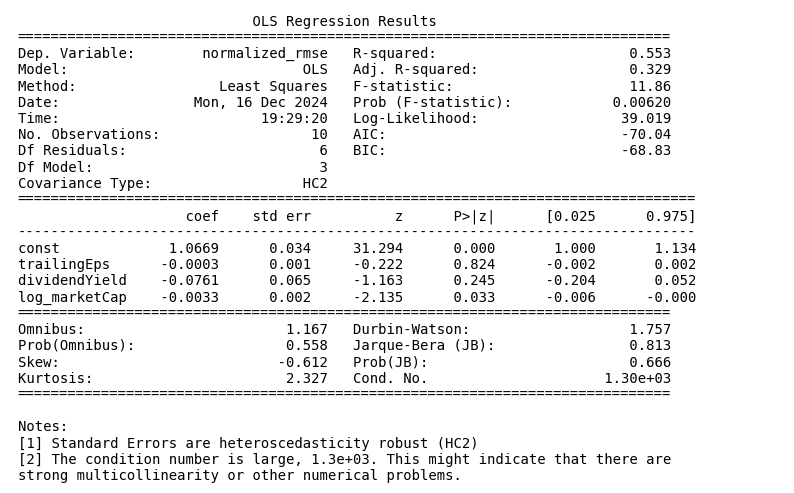

In [217]:
summary_text = result.summary().as_text()

# Render the summary as a PNG
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.99, summary_text, fontsize=10, family='monospace', verticalalignment='top')
plt.axis('off')

# Save as PNG
plt.savefig("5_model_summary.png", dpi=300, bbox_inches='tight')
plt.show()

## Lasso

In [218]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Lasso regression model
lasso = Lasso(alpha=0.01)  # Adjust alpha for regularization strength
lasso.fit(X, Y)

# Predict on the test set
Y_pred = lasso.predict(X)

# Model evaluation
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

# Create a summary DataFrame for coefficients
coef_summary = pd.DataFrame({
    "Feature": X.columns,#[col for col in X.columns],  # Assuming feature names as X1, X2, etc.
    "Coefficient": lasso.coef_
})
coef_summary = coef_summary[coef_summary["Coefficient"] != 0]  # Optional: Filter non-zero coefficients

# Print summary
print("Lasso Regression Summary")
print("="*40)
print(f"Alpha (Regularization Strength): {lasso.alpha}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")
print("\nCoefficients:")
print(coef_summary.to_string(index=False))


Lasso Regression Summary
Alpha (Regularization Strength): 0.01
Mean Squared Error (MSE): 0.0001
R-Squared (R2): 0.0000

Coefficients:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


In [219]:
features = coef_summary.Feature

In [220]:
model = OLS(Y, add_constant(X[features]))
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                nan
Time:                        19:29:20   Log-Likelihood:                 34.995
No. Observations:                  10   AIC:                            -67.99
Df Residuals:                       9   BIC:                            -67.69
Df Model:                           0                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9925      0.003    386.403      0.000       0.987       0.998
==============================================================================
Omnibus:                        1.982   Durbin-Watson:                   0.639
Prob(Omnibus):                  0.371   Jarque-Bera (JB):                1.240
Skew:                          -0.804   Prob(JB):                        0.538
Kurtosis:                       2.374   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""